In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import matplotlib as mpl

### Load data

In [2]:
def get_df():
    df = []
    for fname in glob.glob("csse_covid_19_data/csse_covid_19_daily_reports/*.csv"):
        report_date = fname.split("/")[-1].replace(".csv", "")
        _df = pd.read_csv(fname)
        _df["report_date"] = report_date
        _df.columns = [col.replace("/", "_").replace(" ","_") for col in _df.columns]
        df.append(_df)
    df = pd.concat(df)
    df["Last_Update"] = pd.to_datetime(df["Last_Update"])
    df["report_date"] = pd.to_datetime(df["report_date"])
    df["date"] = df["report_date"] # seems to make more sense than the "Last Update"
    df = df.sort_values(by="date")
    df = df.drop_duplicates()
    return df

In [3]:
def merge(df):
    # for merging several countries/regions
    df = df.groupby("date").sum()
    df = df.reset_index()
    return df

df = get_df()
df = df[df["Country_Region"] == "Germany"]
#df = merge(df[df["Country_Region"] == "US"])
#df = merge(df[df["Country_Region"].apply(lambda x : "Korea" in x)])
#df = merge(df[df["Country_Region"].apply(lambda x : "China" in x)])
#df = df[df["Country_Region"] == "Italy"]
#df = df[df["Country_Region"] == "Japan"]
#df = df[df["Country_Region"] == "Belgium"]
#df = df[df["Country_Region"] == "Iran"]
#df = df[df["Country_Region"] == "Spain"]
#df = df[df["Country_Region"] == "France"]
#df = df[df["Country_Region"] == "Sweden"]


for field in ["Confirmed", "Deaths", "Recovered"]:
    df[f"{field}_diff"] = df[field].diff()
    df[f"{field}_diff_diff"] = df[f"{field}_diff"].diff()

In [4]:
df.drop(
    columns=[
        col
        for col in [
            "Province_State",
            "report_date",
            "Latitude",
            "Longitude",
            "Lat",
            "Long_",
            "FIPS",
            "Admin2",
            "Combined_Key",
            "Active"
        ]
        if col in df
    ]
).tail()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,date,Confirmed_diff,Confirmed_diff_diff,Deaths_diff,Deaths_diff_diff,Recovered_diff,Recovered_diff_diff
2320,Germany,2020-03-31 23:43:43,71808.0,775.0,16100.0,2020-03-31,4923.0,133.0,130.0,18.0,2600.0,-1689.0
2371,Germany,2020-04-01 21:58:34,77872.0,920.0,18700.0,2020-04-01,6064.0,1141.0,145.0,15.0,2600.0,0.0
2453,Germany,2020-04-02 23:25:14,84794.0,1107.0,22440.0,2020-04-02,6922.0,858.0,187.0,42.0,3740.0,1140.0
2509,Germany,2020-04-03 22:46:20,91159.0,1275.0,24575.0,2020-04-03,6365.0,-557.0,168.0,-19.0,2135.0,-1605.0
2563,Germany,2020-04-04 23:34:04,96092.0,1444.0,26400.0,2020-04-04,4933.0,-1432.0,169.0,1.0,1825.0,-310.0


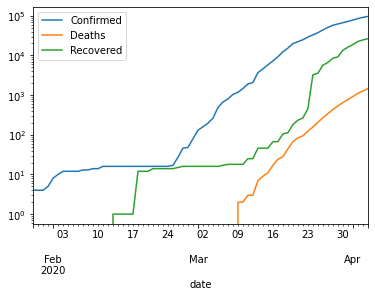

In [5]:
fig, ax = plt.subplots()
df.plot(x="date", y="Confirmed", ax=ax)
df.plot(x="date", y="Deaths", ax=ax)
df.plot(x="date", y="Recovered", ax=ax)
ax.set_yscale("log")

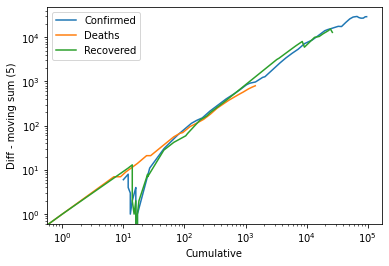

In [6]:
# inspired by https://aatishb.com/covidtrends/
for field in ["Confirmed", "Deaths", "Recovered"]:
    plt.plot(df[field], df[f"{field}_diff"].rolling(5).sum(), label=field)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Diff - moving sum (5)")
plt.xlabel("Cumulative")
plt.legend()

In [7]:
def colorline(x, y, ax, **kwargs):
    from matplotlib.collections import LineCollection
    z = np.linspace(0.0, 1.0, len(x))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, array=z, **kwargs)
    ax.add_collection(lc)
    return lc

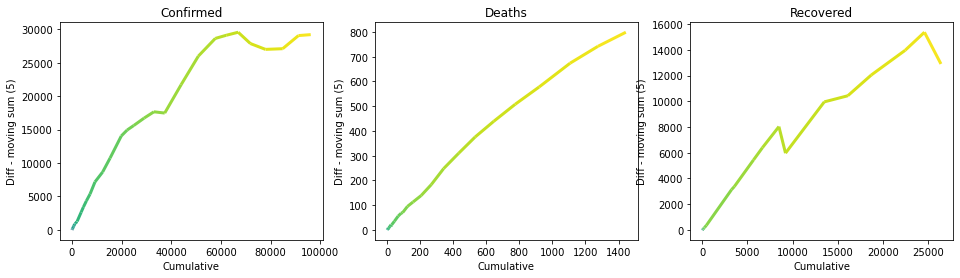

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
for ax, field in zip(axs, ["Confirmed", "Deaths", "Recovered"]):
    colorline(df[field], df[f"{field}_diff"].rolling(5).sum(), ax, linewidth=3)
    ax.autoscale()
    ax.set_title(field)
    ax.set_ylabel("Diff - moving sum (5)")
    ax.set_xlabel("Cumulative")

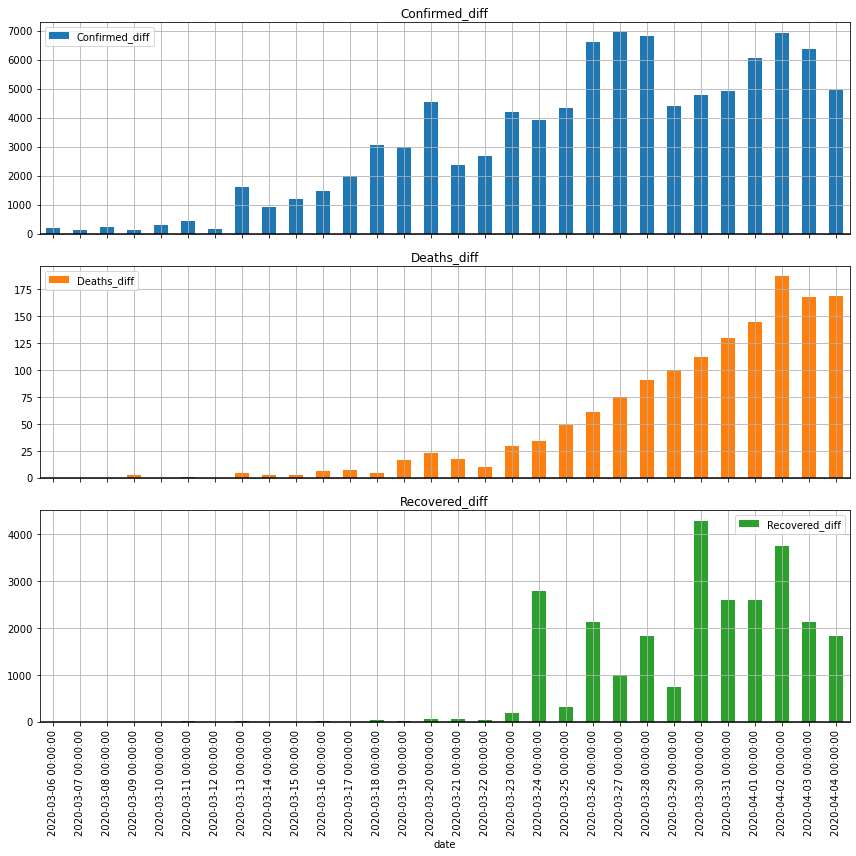

In [9]:
axs = df.iloc[-30:].plot.bar(
    x="date",
    #y=["Confirmed_diff_diff", "Deaths_diff_diff", "Recovered_diff_diff"],
    y=["Confirmed_diff", "Deaths_diff", "Recovered_diff"],
    subplots=True,
    figsize=(12, 12)
)
for ax in axs:
    ax.axhline(0, color="black")
    #ax.set_yscale("symlog")
    ax.grid()
fig = axs[0].get_figure()
fig.tight_layout()
#fig.savefig("diff_diff.pdf")

### Fit exponential

In [10]:
def func(x, a, b, c):
    return a * np.exp(b * (x - c))

In [11]:
def get_xy(df, field="Confirmed"):
    # DataFrame contains cumulative cases (called 'int' here)
    # np.diff gives new confirmed cases per day
    x_int = df["date"].astype("int").values
    x_int = (x_int - x_int[0]) / 1e9 / 3600 / 24
    x = x_int[1:]
    y = np.diff(df[field]) / np.diff(x_int)
    y = np.nan_to_num(y)
    y_int = df[field].values
    y_int = np.nan_to_num(y_int)
    
    return x, y, x_int, y_int

Exponential fit for new and cumulative cases per day:

In [12]:
fields = ["Confirmed", "Deaths"]

In [13]:
fit_results_diff = {}
fit_results_int = {}
fit_data = {}
for field in fields:
    fit_data[field] = get_xy(df, field=field)
    x, y, x_int, y_int = fit_data[field]
    est_b_y = np.log(2) / np.count_nonzero(y > y[-1] * 0.5)
    est_b_y_int = np.log(2) / np.count_nonzero(y_int > y_int[-1] * 0.5)
    est_c_y = x[y>0][0]
    est_c_y_int = x_int[y_int>0][0]
    fit_results_diff[field] = scipy.optimize.curve_fit(func, x, y, p0=(1, est_b_y, est_c_y))
    fit_results_int[field] = scipy.optimize.curve_fit(func, x_int, y_int, p0=(1, est_b_y_int, est_c_y_int))

<ipython-input-10-54abd0354d15>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * (x - c))


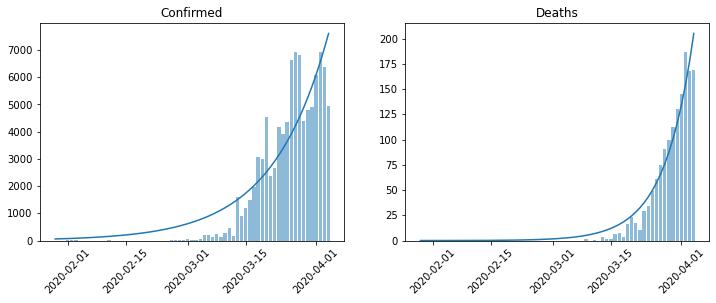

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for ax, field in zip(axs, fields):
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]
    ax.bar(df["date"][1:], y, alpha=0.5)
    ax.plot(df["date"][1:], func(x, *popt))
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)

Plot both new and cumulative

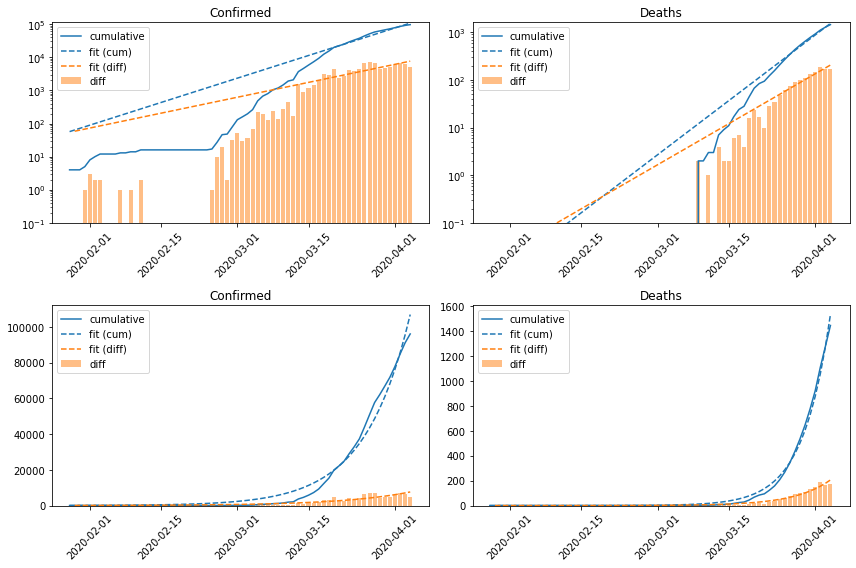

In [15]:
fig, axs = plt.subplots(ncols=len(fields), nrows=2, figsize=(12, 8))

for row, scale in zip(range(2), ["log", "linear"]):
    for col, field in enumerate(fields):
        ax = axs[row][col]

        x, y, x_int, y_int = fit_data[field]
        popt, pcov = fit_results_diff[field]
        popt_int, pcov_int = fit_results_int[field]

        ax.plot(df["date"], y_int, label="cumulative", color="C0")
        ax.plot(df["date"], func(x_int, *popt_int), "--", label="fit (cum)", color="C0")

        ax.bar(df["date"][1:], y, label="diff", color="C1", alpha=0.5)
        ax.plot(df["date"][1:], func(x, *popt), "--", label="fit (diff)", color="C1")

        ax.xaxis.set_tick_params(rotation=45)
        ax.legend()

        #ax.set_yscale("log")
        if scale == "log":
            ax.set_ylim(bottom=1e-1)
        #ax.set_ylim(auto=True)
        #ax.set_yscale("linear")
        ax.set_yscale(scale)

        ax.set_title(field)
fig.tight_layout()

Fit gaussian * exponential (inspired by otmar)

In [16]:
def func2(x, p1, p2, p3, c=0):
    xp = x - c
    return p1 * np.exp(p2 * xp + p3 * xp ** 2)

In [17]:
import uncertainties
from uncertainties import umath

In [18]:
def func2_unc(x, p1, p2, p3, c=0):
    xp = x - c
    return p1 * umath.exp(p2 * xp + p3 * xp **2)

Maximum on 2020-04-15 00:00:00
Fitted between 2020-03-03 00:00:00 and 2020-04-04 00:00:00


array([ 5.26650234e+00,  3.90665320e-01, -6.01323631e-03,  4.54891555e+01])

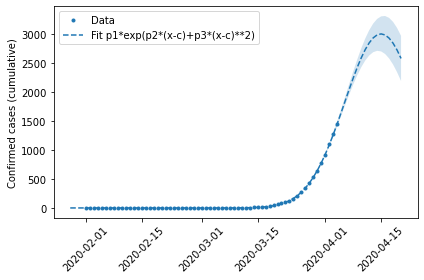

In [19]:
field = "Deaths"
x, y, x_int, y_int = fit_data[field]
goback = None
start = 35
if goback is not None:
    x_int_fit = x_int[:-goback]
    y_int_fit = y_int[:-goback]
    last_date = df.date.iloc[-(goback-1)]
else:
    x_int_fit = x_int
    y_int_fit = y_int
    last_date = df.date.iloc[-1]
x_int_fit = x_int_fit[start:]
y_int_fit = y_int_fit[start:]
first_date = df.date.iloc[start]
popt, pcov = scipy.optimize.curve_fit(
    func2, x_int_fit, y_int_fit,
    #p0=[ 3.16544814e-07,  9.73195427e-01, -9.69697815e-03, 1],
    #p0=[0.7, 0.04, 0, 0],
    p0 = [0.1,  0.4, -3.5e-03,  25],
    #p0=[ 2.29219949e-01,  4.91781600e-01, -4.63424405e-03,  1.86371851e+01],
    bounds=([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, 0., np.inf])
)

#popt = [0.1,  0.4, -3.5e-03,  25]

popt_unc = uncertainties.correlated_values(list(popt), pcov)

dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-04-20", freq="d")
days = np.arange(len(dates_extrap))

unc_values = [func2_unc(day, *popt_unc) for day in days]
unc_n = np.array([v.n for v in unc_values])
unc_std = np.array([v.std_dev for v in unc_values])

fig, ax = plt.subplots()
ax.plot(df.date, df[field], ".", color="C0", label="Data")
ax.plot(dates_extrap, func2(days, *popt), color="C0", linestyle="--", label="Fit p1*exp(p2*(x-c)+p3*(x-c)**2)")
ax.fill_between(dates_extrap, unc_n - unc_std, unc_n + unc_std, alpha=0.2)
if goback is not None:
    ax.axvline(last_date, linestyle="--")
ax.xaxis.set_tick_params(rotation=45)
#plt.yscale("log")
ax.set_ylabel("Confirmed cases (cumulative)")
print(f"Maximum on {dates_extrap[np.argmax(func2(days, *popt))]}")
ax.legend(loc="upper left")
fig.tight_layout()
print(f"Fitted between {first_date} and {last_date}")
popt

Development of relative increase per day

<ipython-input-20-b7e2d9cff0a3>:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(df["date"][1:], y / y_int[:-1], ".", color="C0")
<ipython-input-20-b7e2d9cff0a3>:16: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(df["date"][1:], y / y_int[:-1], ".", color="C0")
<ipython-input-20-b7e2d9cff0a3>:19: RuntimeWarning: divide by zero encountered in true_divide
  moving_average(y / y_int[:-1], n=window),
<ipython-input-20-b7e2d9cff0a3>:19: RuntimeWarning: invalid value encountered in true_divide
  moving_average(y / y_int[:-1], n=window),


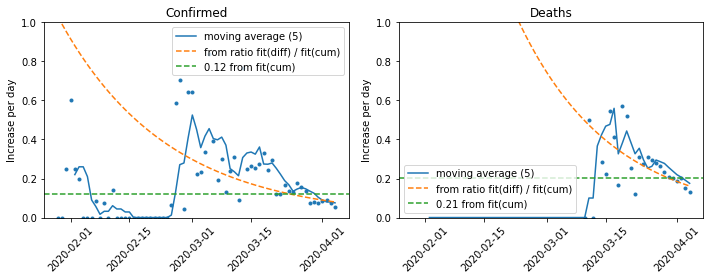

In [20]:
def moving_average(a, n=3) :
    ret = np.cumsum(np.nan_to_num(a, posinf=0, neginf=0), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
window = 5

for ax, field in zip(axs, fields):

    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]

    inc_from_param = np.exp(popt_int[1]) - 1
    ax.plot(df["date"][1:], y / y_int[:-1], ".", color="C0")
    ax.plot(
        df["date"][window:],
        moving_average(y / y_int[:-1], n=window),
        color="C0",
        label=f"moving average ({window})"
    )
    ax.plot(
        df["date"][1:],
        func(x, *popt) / func(x_int, *popt_int)[:-1],
        color="C1",
        linestyle="--",
        label="from ratio fit(diff) / fit(cum)"
    )
    ax.axhline(inc_from_param, linestyle="--", color="C2", label=f"{inc_from_param:.2f} from fit(cum)")
    ax.set_ylabel("Increase per day")
    ax.xaxis.set_tick_params(rotation=45)
    ax.legend()
    ax.set_title(field)
    ax.set_ylim(0, 1)
fig.tight_layout()    
fig.savefig("increase_moving_average.pdf")

### Extrapolation of cumulative cases

Extrapolated until 2020-04-20 00:00:00
Confirmed: 647163.8954202223
Deaths: 30308.78157115667


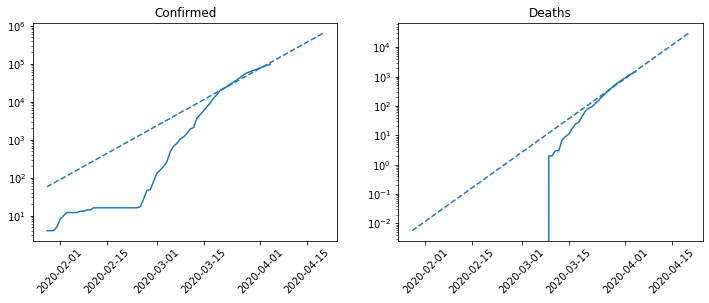

In [21]:
dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-04-20", freq="d")
days = np.arange(len(dates_extrap))

fig, axs = plt.subplots(ncols=len(fields), figsize=(12, 4))

print(f"Extrapolated until {dates_extrap[-1]}")

for ax, field in zip(axs, fields):
    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    pred = func(days, *popt_int)
    ax.plot(df["date"], y_int, label="confirmed", color="C0")
    ax.plot(dates_extrap, pred, "--", color="C0")
    ax.set_yscale("log")
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)
    print(f"{field}: {pred[-1]}") # predicted by end of range

### Fitted Parameters and doubling time

In [22]:
fit_results_int

{'Confirmed': (array([  5.24339486,   0.1125077 , -21.20074229]),
  array([[ 5.07544853e+12, -6.24040112e+02,  8.60358824e+12],
         [-6.24039366e+02,  1.09511214e-05, -1.05782502e+03],
         [ 8.60358824e+12, -1.05782628e+03,  1.45842737e+13]])),
 'Deaths': (array([ 2.85614096,  0.18656712, 33.3142829 ]),
  array([[ 4.26896877e+12, -1.70122602e+02,  8.01139674e+12],
         [-1.70122055e+02,  9.31632825e-06, -3.19259438e+02],
         [ 8.01139674e+12, -3.19260450e+02,  1.50346562e+13]]))}

In [23]:
fit_results_diff

{'Confirmed': (array([  4.38609321,   0.07374453, -34.13902766]),
  array([[ 1.85046040e+14, -1.59667681e+04,  5.71580848e+14],
         [-1.59667862e+04,  3.96644487e-05, -4.93190780e+04],
         [ 5.71580848e+14, -4.93190223e+04,  1.76553179e+15]])),
 'Deaths': (array([ 1.63441839,  0.14168031, 32.89097469]),
  array([[2.48503791e+12, 1.82966889e+03, 1.07314974e+13],
         [1.82966849e+03, 3.79757147e-05, 7.90132918e+03],
         [1.07314974e+13, 7.90133098e+03, 4.63433720e+13]]))}

In [24]:
np.log(2) / fit_results_int["Confirmed"][0][1]

6.160886676529204

In [25]:
np.log(2) / fit_results_int["Deaths"][0][1]

3.71526967578054

### Death rate

In [26]:
df["death_rate"] = df["Deaths"] / df["Confirmed"]

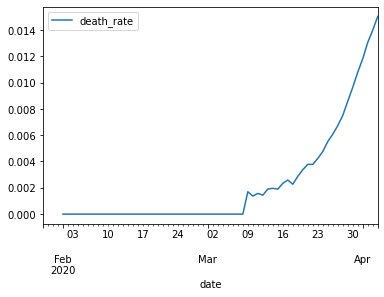

In [27]:
df.plot(x="date", y="death_rate")